<a href="https://colab.research.google.com/github/luciaschmidtsantiago/probai-2025/blob/main/ProbAI2025_GraphCNN_DeepEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%%capture
!pip install git+https://github.com/vabor112/pems-regression.git

In [2]:
# Basic Imports
import random
import numpy as np
import torch
import importlib.resources
import pickle
import networkx as nx
from functools import partial

import warnings
from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)

# Pytorch Neural Networks
import torch.nn as nn
import torch.nn.functional as F

# Graph CNNs
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# GeometricKernels
import geometric_kernels
import geometric_kernels.torch
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels import MaternGeometricKernel
from geometric_kernels.frontends.gpytorch import GPyTorchGeometricKernel

# Metrics
from pems_regression.metrics import (
    rmse as orig_rmse,
    full_cov_nll as orig_full_cov_nll,
    diag_cov_nll as orig_diag_cov_nll,
)

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pems_regression.plotting.pems import (
    plot_PEMS,
    plot_prediction as orig_plot_prediction,
    plot_uncertainty as orig_plot_uncertainty,
)

# Utils
from pems_regression.utils import dcn

INFO:geometric_kernels:Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO:geometric_kernels:We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.
INFO:geometric_kernels.torch:Torch backend enabled.
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Setup

In [3]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    torch.set_default_device("cpu")
    device = torch.device("cpu")
torch.set_default_dtype(torch.float64)

# Settings and Seeds

In [4]:
%%capture

NUM_TRAIN = 250
NUM_MODELS_IN_ENSEMBLE = 3
NN_WIDTH = 100
NN_DEPTH = 2

# Note: we will not be changing train/test split between experiments for visualization purposes
random.seed(1111)
np.random.seed(1111)
torch.manual_seed(1111)

# Whether or not to remove plot backgrounds
NO_BACKGROUND = False

# Data

## Prepare Data

The nasty details of the PEMS dataset preparation are hidden away in the preprocessing module in https://github.com/spbu-math-cs/Graph-Gaussian-Processes/tree/main/examples/utils.

In [5]:
with importlib.resources.files("pems_regression.resources").joinpath(
    "processed_pems_data.pkl"
).open("rb") as f:
    nx_graph, data = pickle.load(f)

# Splitting data into train and test
random_perm = np.random.permutation(np.arange(data[0].shape[0]))
train_vertex, test_vertex = random_perm[:NUM_TRAIN], random_perm[NUM_TRAIN:]
xs_train = torch.tensor(data[0][train_vertex], dtype=torch.int64)
ys_train = torch.tensor(data[1][train_vertex], dtype=torch.float64)

xs_test = torch.tensor(data[0][test_vertex], dtype=torch.int64)
ys_test = torch.tensor(data[1][test_vertex], dtype=torch.float64)

num_nodes = len(nx_graph)
xs = torch.arange(num_nodes)

# Note: since there is lots of _actually_ unknown y-s, the `ys` array will have
# lots of NaN-s.
ys = torch.full((num_nodes,), np.nan, dtype=torch.float64)
ys[xs_train.squeeze()] = ys_train.squeeze()
ys[xs_test.squeeze()] = ys_test.squeeze()
ys = ys[:, None]

Center and normalize the outputs

In [6]:
# Important to compute these _before_ centering/normalization
y_min = min(torch.min(ys_train), torch.min(ys_test))
y_max = max(torch.max(ys_train), torch.max(ys_test))

orig_mean, orig_std = torch.mean(ys_train), torch.std(ys_train)
print(f"orig_mean = {orig_mean} | orig_std = {orig_std}.")
ys_train = (ys_train - orig_mean) / orig_std
ys_test = (ys_test - orig_mean) / orig_std
ys = (ys - orig_mean) / orig_std

orig_mean = 51.06000000000001 | orig_std = 17.334115675887833.


Extract adjacency matrix from the loaded networkx graph and check that it passes sanity checks

In [7]:
adj_mat = torch.tensor(nx.to_numpy_array(nx_graph))

# Sanity checks
assert torch.allclose(adj_mat, adj_mat.T), "Adjacency matrix is not symmetric!"
assert torch.all(adj_mat >= 0.0), "Adjacency matrix contains negative elements!"
assert (
    torch.sum(adj_mat.diagonal() ** 2) == 0.0
), "Adjacency matrix has non-zeros on diagonal!"

Prepare data in the PyTorch Geometric format

In [8]:
masked_ys = torch.nan_to_num(ys)
masked_ys[xs_test.squeeze()] = 0.0

train_mask = torch.full((num_nodes,), False, dtype=torch.bool)
train_mask[xs_train.squeeze()] = True
test_mask = torch.full((num_nodes,), False, dtype=torch.bool)
test_mask[xs_test.squeeze()] = True

pyg_data = Data(
    x=masked_ys,
    edge_index=adj_mat.to_sparse().indices(),
    edge_weight=adj_mat.to_sparse().values(),
    y=ys,
    train_mask=train_mask,
    test_mask=test_mask,
)

## Metrics shorthands

In [9]:
rmse = partial(orig_rmse, observation=ys_test, original_std=orig_std)
full_cov_nll = partial(orig_full_cov_nll, observation=ys_test)
diag_cov_nll = partial(orig_diag_cov_nll, observation=ys_test)

## Metrics for Trivial Baselines

In [10]:
# The trivial baseline: returns orig_mean as prediction and orig_std as standard
# deviation (which turn into zero and one after normalization and centering).
trivial_mean = torch.zeros_like(ys_test)
trivial_std = torch.ones_like(ys_test)
trivial_cov = torch.eye(ys_test.shape[0])

trivial_rmse = rmse(trivial_mean)

# The following two are supposed to coincide, we only compute both for the sake
# of a sanity check. Also note, we do not uncenter/unnormalize data before
# computing nll. This is intentional: it only changes all the nll values by the
# _same_ constant, and the absolute value of nll has little meaning anyway.
trivial_diag_nll = diag_cov_nll(trivial_mean, trivial_std)
trivial_full_nll = full_cov_nll(trivial_mean, trivial_cov)

print(f"Test RMSE is {trivial_rmse:.2f}")
print(f"Test diag-NLL is {trivial_diag_nll:.2f}")
print(f"Test full-NLL is {trivial_full_nll:.2f}")

Test RMSE is 16.43
Test diag-NLL is 102.62
Test full-NLL is 102.62


## Plotting Shorthands

In [11]:
vmin, vmax = 10, 70
alpha_global = 0.6
alpha_local = 0.95

In [12]:
plot_prediction = partial(
    orig_plot_prediction,
    nx_graph=nx_graph,
    xs=xs,
    orig_mean=orig_mean,
    orig_std=orig_std,
    vmin=vmin,
    vmax=vmax,
    xs_train=xs_train,
    alpha_global=alpha_global,
    alpha_local=alpha_local,
)

plot_uncertainty = partial(
    orig_plot_uncertainty,
    nx_graph=nx_graph,
    xs=xs,
    orig_std=orig_std,
    vmin=0,
    vmax=18,
    xs_train=xs_train,
    alpha_global=alpha_global,
    alpha_local=alpha_local,
)

## Visualize Data

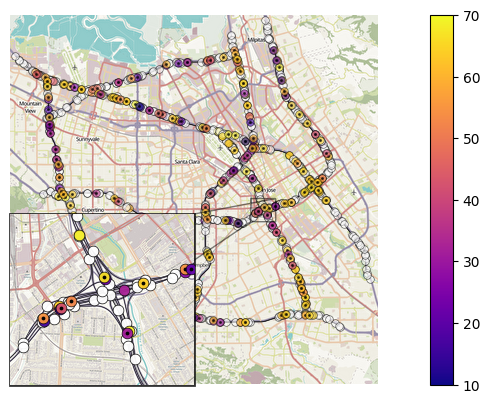

In [13]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plot_PEMS(
    nx_graph,
    dcn(ys),
    dcn(xs),
    (dcn(orig_mean), dcn(orig_std)),
    ax=ax,
    fig=fig,
    cax=cax,
    vmin=vmin,
    vmax=vmax,
    bbox=(37.450, 37.210, -121.80, -122.10),
    nodes_to_label=dcn(xs_train),
    node_size=30,
    alpha=alpha_global,
    edge_linewidth=0.4,
    cmap_name="plasma",
)

inner_ax = ax.inset_axes((0, -0.02, 0.5, 0.5))


plot_PEMS(
    nx_graph,
    dcn(ys),
    dcn(xs),
    (dcn(orig_mean), dcn(orig_std)),
    ax=inner_ax,
    fig=fig,
    cax=None,
    vmin=vmin,
    vmax=vmax,
    bbox=(37.330741, 37.315718, -121.883005, -121.903327),
    nodes_to_label=dcn(xs_train),
    node_size=60,
    alpha=alpha_local,
    edge_linewidth=0.4,
    cmap_name="plasma",
)

inner_ax.patch.set_edgecolor((0, 0, 0, 0.8))
inner_ax.patch.set_linewidth(2)

ax.indicate_inset_zoom(inner_ax, edgecolor=(0, 0, 0, 0.8))

plt.show()

## Visualize Baselines

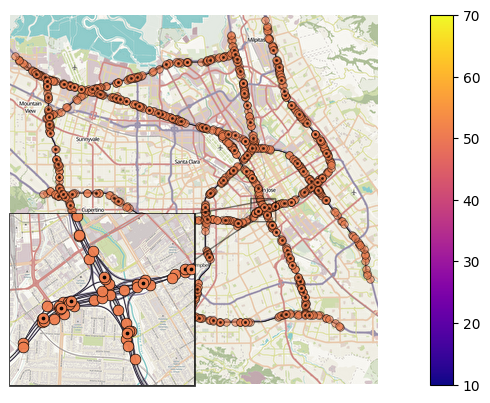

In [14]:
plot_prediction(torch.zeros_like(ys))

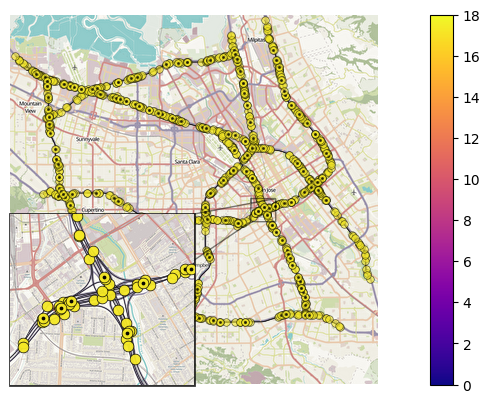

In [15]:
plot_uncertainty(torch.ones_like(ys))

Cleaning up

In [16]:
del vmin, vmax

# Fitting a Deterministic Graph Neural Network

## Model

In [17]:
class GCNModel(torch.nn.Module):
    def __init__(
        self, hidden_layer_size=10, num_intermediate_layers=0, input_dropout=False
    ):
        super().__init__()
        self.input_dropout = input_dropout

        self.first_layer = GCNConv(1, hidden_layer_size)

        self.intermediate_layers = [
            GCNConv(hidden_layer_size, hidden_layer_size)
            for _ in range(num_intermediate_layers)
        ]

        self.last_layer = GCNConv(hidden_layer_size, 1)

    def forward(self, x, edge_index, edge_weight):
        if self.input_dropout:
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.first_layer(x, edge_index, edge_weight)
        x = F.relu(x)

        for layer in self.intermediate_layers:
            x = layer(x, edge_index, edge_weight)
            x = F.relu(x)

        x = self.last_layer(x, edge_index, edge_weight)

        return x

## Training Routines

In [18]:
def train(
    data, model, optimizer, criterion, epochs=500, *, only_print_end_result=False
):
    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients.
        outputs = model(
            data.x, data.edge_index, data.edge_weight
        ).squeeze()  # Perform a single forward pass.
        loss = criterion(
            outputs[data.train_mask], data.y.squeeze()[data.train_mask]
        )  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        if (not only_print_end_result and (epoch % 100) == 0) or (
            only_print_end_result and epoch + 1 == epochs
        ):
            print(f"Epochs:{epoch + 1:5d} | " f"Cur loss: {loss:.10f}")


def get_gcnn_predictions(
    layer_width,
    num_intermediate_layers,
    only_print_end_result=False,
    num_training_iterations=500,
):
    model = GCNModel(layer_width, num_intermediate_layers=num_intermediate_layers)
    model.double()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.MSELoss()
    model.train()
    train(
        pyg_data,
        model,
        optimizer,
        criterion,
        num_training_iterations,
        only_print_end_result=only_print_end_result,
    )
    model.eval()

    predictions = model(pyg_data.x, pyg_data.edge_index, pyg_data.edge_weight)

    return predictions

## Train the Model

In [19]:
shallow_nn_pred = get_gcnn_predictions(NN_WIDTH, NN_DEPTH - 1)

Epochs:    1 | Cur loss: 0.9987501268
Epochs:  101 | Cur loss: 0.2509162425
Epochs:  201 | Cur loss: 0.2328345132
Epochs:  301 | Cur loss: 0.2268480021
Epochs:  401 | Cur loss: 0.2211235996


## Metrics

In [20]:
# shallow_nn_best_pred, _ = print_metrics(shallow_nn_results)
nn_rmse = rmse(shallow_nn_pred[xs_test])
print(f"RMSE: {nn_rmse:.2f}")

RMSE: 13.51


## Visualize Results

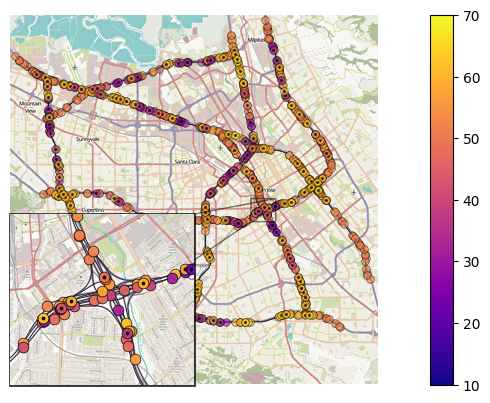

In [21]:
plot_prediction(shallow_nn_pred)

# Practice: Fitting an Ensemble of Graph Neural Networks

## Train the Model

In [26]:
# Task: train `NUM_MODELS_IN_ENSEMBLE` instances of GCNModel.
predictions = []

for i in range(NUM_MODELS_IN_ENSEMBLE):
  prediction = get_gcnn_predictions(NN_WIDTH, NN_DEPTH - 1, only_print_end_result=True)
  predictions.append(prediction.detach().numpy())

predictions_array = np.stack(predictions, axis=1)

# Suggestion: use the same
# `get_gcnn_predictions(NN_WIDTH, NN_DEPTH - 1, only_print_end_result=True)`
# as above.

Epochs:  500 | Cur loss: 0.2266562312
Epochs:  500 | Cur loss: 0.2282298014
Epochs:  500 | Cur loss: 0.2223417647


In [27]:
# Task: compute the prediction (mean over preditctions of individual neural networks)
ensemble_pred =  np.mean(predictions_array, axis=1)
# Task: compute the uncertainty (standard deviation of preditctions of individual neural networks)
ensemble_std =  np.std(predictions_array, axis=1)

In [29]:
ensemble_pred = torch.tensor(ensemble_pred)
ensemble_std = torch.tensor(ensemble_std)


## Metrics

In [30]:
rmse_ens = rmse(ensemble_pred[xs_test])
nll_ens = diag_cov_nll(ensemble_pred[xs_test], ensemble_std[xs_test])

print(f"Ensemble RMSE: {rmse_ens:.2f}")
print(f"Ensemble NLL: {nll_ens:.2f}")

Ensemble RMSE: 13.53
Ensemble NLL: 329115.42


## Visualize Results

Visualize prediction

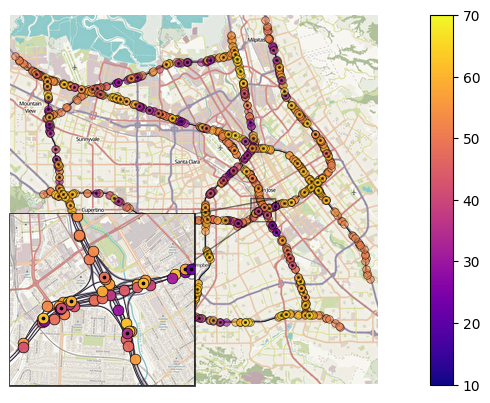

In [31]:
plot_prediction(ensemble_pred)

Visualize uncertainty

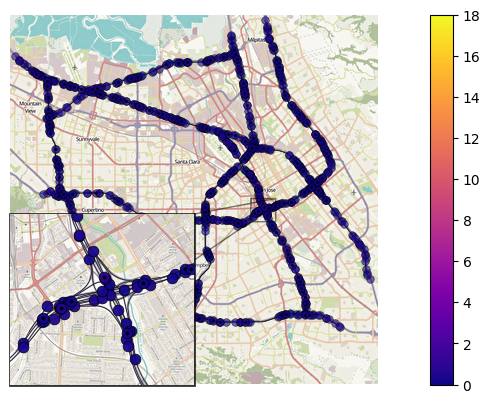

In [32]:
plot_uncertainty(ensemble_std)